In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.schedulers import CoreScheduler
from rubin_scheduler.scheduler.example import example_scheduler, run_sched, generate_blobs
from rubin_scheduler.scheduler.model_observatory import KinemModel, ModelObservatory
from rubin_scheduler.scheduler.utils import (
    SchemaConverter,
    empty_observation,
    make_rolling_footprints, Footprint,
    restore_scheduler,
    run_info_table,
    season_calc,
    EuclidOverlapFootprint, 
    HpInLsstFov
)
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.scheduler.utils import generate_all_sky, IntRounded
from rubin_scheduler.utils import survey_start_mjd, _approx_ra_dec2_alt_az, approx_ra_dec2_alt_az, Site

In [2]:
# Modify the footprint
nside = 32
mjd_start = survey_start_mjd()
nslice = 4
sky = EuclidOverlapFootprint(nside=nside, smc_radius=4, lmc_radius=6)
footprints_hp_array, labels = sky.return_maps()

# Use the Almanac to find the position of the sun at the start of survey
almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

wfd_indx = np.where((labels == "lowdust") | (labels == "LMC_SMC") | (labels == "virgo"))[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprint_mask = footprints_hp["r"] * 0
footprint_mask[np.where(footprints_hp["r"] > 0)] = 1

repeat_night_weight = None

# Use the Almanac to find the position of the sun at the start of survey
almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

footprints = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=mjd_start,
    sun_ra_start=sun_ra_start,
    nside=nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=4,
)

blobs = generate_blobs(
    nside,
    footprints=footprints,
    mjd_start=mjd_start,
)

scheduler = CoreScheduler(blobs, nside=nside)

In [3]:
#scheduler = example_scheduler(mjd_start=mjd_start)
km = KinemModel(mjd0=mjd_start)
km.setup_telescope(abs_azimuth_minpos=270, abs_azimuth_maxpos=90)
mo = ModelObservatory(mjd_start=mjd_start, kinem_model=km)

In [4]:
conditions = mo.return_conditions()
print(conditions.mjd)
scheduler.update_conditions(conditions)
print(scheduler.conditions.mjd)

60796.0
60796.0


In [5]:
print(scheduler.conditions.mjd, mjd_start)
scheduler.survey_lists

60796.0 60796.0


[[<BlobSurvey survey_name='Pair survey 33.0 u_g' at 0x1a1df5950>,
  <BlobSurvey survey_name='Pair survey 33.0 u_r' at 0x1a23b47d0>,
  <BlobSurvey survey_name='Pair survey 33.0 g_r' at 0x1a22bca10>,
  <BlobSurvey survey_name='Pair survey 33.0 r_i' at 0x1a24449d0>,
  <BlobSurvey survey_name='Pair survey 33.0 i_z' at 0x1a23bc990>,
  <BlobSurvey survey_name='Pair survey 33.0 z_y' at 0x1a2358850>,
  <BlobSurvey survey_name='Pair survey 33.0 y_y' at 0x1a24247d0>]]

In [6]:
km = KinemModel(mjd0=mjd_start)
km.setup_telescope(abs_azimuth_minpos=270, abs_azimuth_maxpos=90)
mo = ModelObservatory(mjd_start=mjd_start, kinem_model=km)

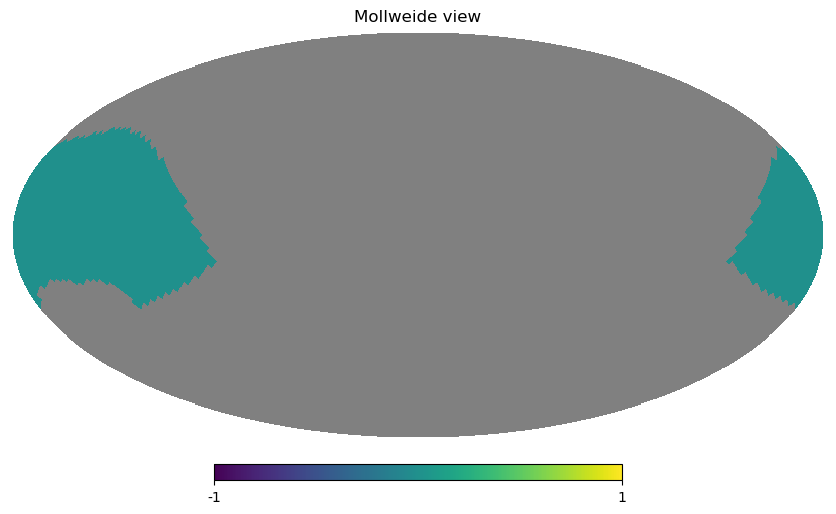

In [7]:
conditions = mo.return_conditions()
hp.mollview(scheduler.survey_lists[0][3].basis_functions[-3](conditions))

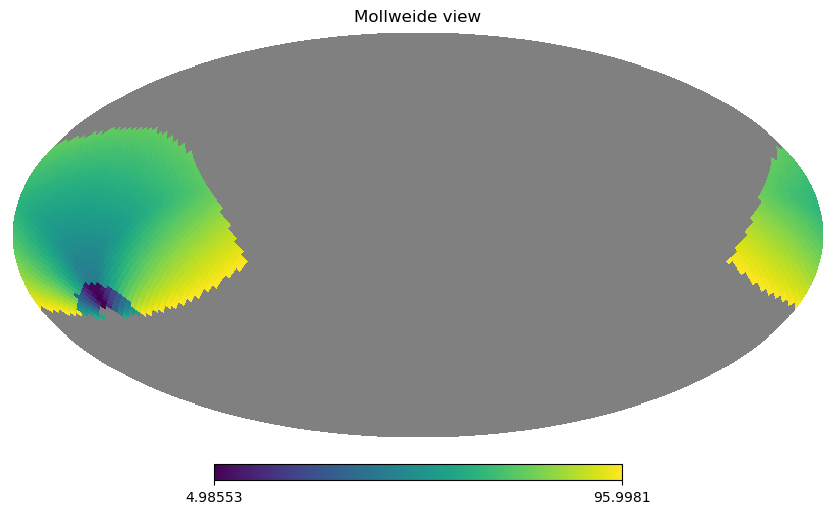

In [8]:
sky = generate_all_sky()

slewtimes = km.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), conditions.mjd)
hp.mollview(slewtimes)
#hp.projscatter(np.degrees(obs['RA']), np.degrees(obs['dec']), lonlat=True)

In [9]:
mjd_start = survey_start_mjd()
scheduler = example_scheduler(mjd_start=mjd_start)
km = KinemModel(mjd0=mjd_start)
km.setup_telescope(abs_azimuth_minpos=270, abs_azimuth_maxpos=90)
mo = ModelObservatory(mjd=mjd_start, mjd_start=mjd_start, kinem_model=km)
mo, scheduler, observations = sim_runner(
    mo,
    scheduler,
    survey_length=3.0,
    verbose=False,
    filename=None,
)

fatal: not a git repository (or any of the parent directories): .git


Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:335: RuntimeWarning: All-NaN slice encountered
  indx = np.where(in_map[current_neighbors] == np.nanmax(in_map[current_neighbors]))[0]
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:338: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


Skipped 0 observations
Flushed 692 observations from queue for being stale
Completed 2995 observations
ran in 0 min = 0.0 hours


In [10]:
np.unique(observations['scheduler_note'])

array(['blob_long, gr, a', 'blob_long, gr, b', 'greedy', 'pair_15, iz, a',
       'pair_15, iz, b', 'pair_15, ri, a', 'pair_15, ri, b',
       'pair_33, gr, a', 'pair_33, gr, b', 'pair_33, ri, a',
       'pair_33, ri, b', 'twilight_near_sun, 0', 'twilight_near_sun, 1',
       'twilight_near_sun, 2', 'twilight_near_sun, 3'], dtype='<U40')

In [11]:
import copy
sched_copy = copy.deepcopy(scheduler)
mo_copy = copy.deepcopy(mo)
#scheduler.conditions.mjd[0], mjd_start

In [12]:
if True:
    scheduler = copy.deepcopy(sched_copy)

In [13]:
km = KinemModel(mjd0=mjd_start)
km.setup_telescope(altitude_minpos=40.0, altitude_maxpos=70.0)
mo = ModelObservatory(mjd=observations[-1]['mjd'], mjd_start=mjd_start, kinem_model=km)
scheduler.flush_queue()

In [14]:
vv = sim_runner(
    mo,
    scheduler,
    survey_length=3.0,
    verbose=False,
    filename=None,
)

At time [60799.0626667]:
requested observation was from survey [2, 2]
desired obs [(0, 3.11657569, -1.41336331, 0., 60799.10635883, 30., 'g', -2.21073924, -2.21073924, 2, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', 'pair_33, gr, a', '', 1, 0., nan, 0.55115551, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 'FBS', 'FBS', 'Imaging')]


In [25]:
mo = vv[0]
conditions = mo.return_conditions()
print(conditions.mjd)
sched = vv[1]
observations2 = vv[2]
desired_obs = vv[3]

[60799.0626667]


In [26]:
observations2[np.where(observations2['RA'] != 0)][-1]

(127, 3.11315672, -1.3600918, 60799.06226855, 60799.09413371, 30., 'g', -2.30071721, -2.30071721, 2, 1.48662004, 0.45024108, 0.90086362, 0.79250989, 21.11076005, 3, 4.4463677, 34.4, 0.05002066, 24.28535792, 0.73780701, 0., 0., 0., 0., 0.39510709, -0.77482969, '', 'pair_33, gr, a', '', 1, 11.59085485, nan, 0.55115551, 5.52833453, 4.58737499, 0.71632011, 0.27729535, 2.2721987, 0.39876713, 1.82470218, 1.999403, 46.18657053, -2.79381613, 0, 'FBS', 'FBS', 'Imaging')

In [27]:
desired_obs

array([(0, 3.11657569, -1.41336331, 0., 60799.10635883, 30., 'g', -2.21073924, -2.21073924, 2, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', 'pair_33, gr, a', '', 1, 0., nan, 0.55115551, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 'FBS', 'FBS', 'Imaging')],
      dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U40'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('psudo_pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('scheduler_note', '<U40'), ('target_name', '<U40'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), (

In [28]:
# To recreate the desired_obs, can be hard .. the queue could have been requested a time prior
print(sched.queue_filled, sched.survey_index)

[60799.0626667] [2, 2]


<Figure size 800x600 with 0 Axes>

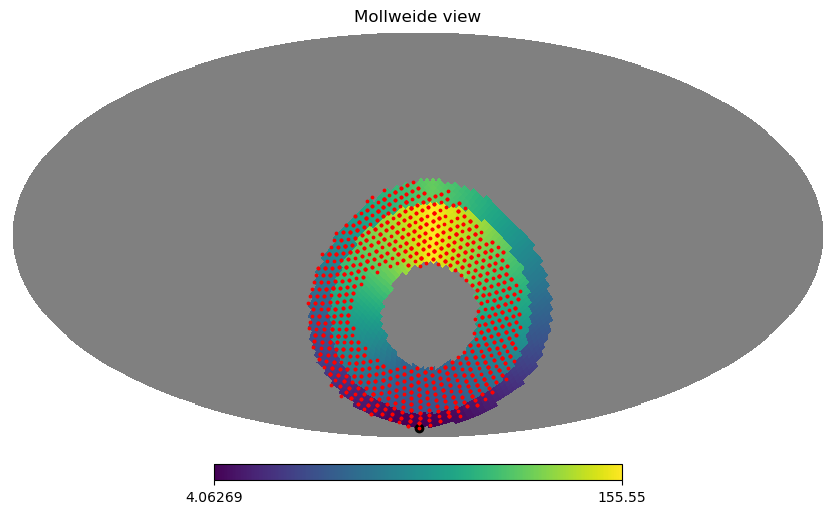

In [34]:
sky = generate_all_sky()
obs = desired_obs

su = sched.survey_lists[sched.survey_index[0]][sched.survey_index[1]]

plt.figure(figsize=(8, 6))
slewtimes = km.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), conditions.mjd)

rot = (180, 0, 0)
hp.mollview(slewtimes, rot=rot)
hp.projscatter(np.degrees(obs['RA']), np.degrees(obs['dec']), lonlat=True, color='k',)

fields = copy.deepcopy(su.fields)
rew = su.calc_reward_function(conditions)
idxs = np.where(np.isfinite(rew))
gfields = fields[su.hp2fields[idxs]]
hp.projscatter(np.degrees(gfields['RA']), np.degrees(gfields['dec']), lonlat=True, color='r', s=3)

plt.show()

In [30]:
conditions.mjd, sched.queue_filled, conditions.mjd == sched.queue_filled

(array([60799.0626667]), array([60799.0626667]), array([ True]))

11636 3346
2.8361600344907854 -1.1073814549606384 2.8129976497445264 -1.100227118543958 [3.11657569] [-1.41336331]
[55.99267701] [189.17377066] [56.1850275] [190.42587388] [39.23292601] [179.07792449] [39.23292601] [179.07792449]


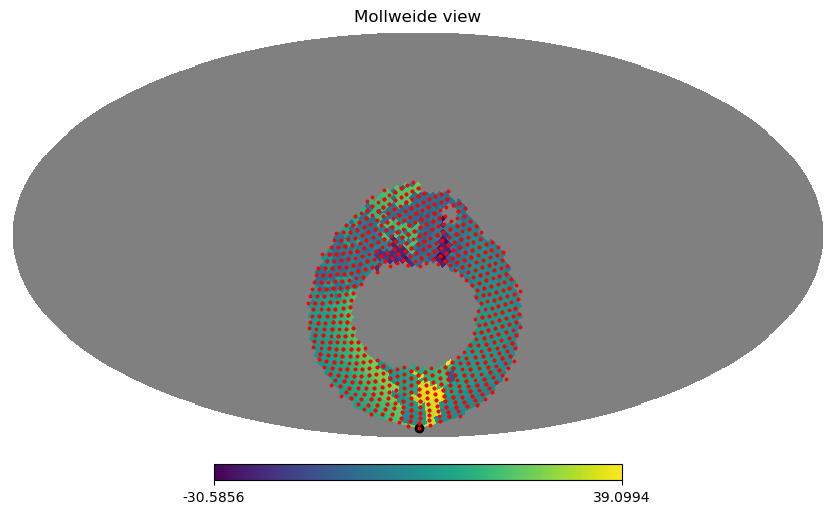

In [35]:
rew = su.calc_reward_function(conditions)
hp.mollview(rew, rot=rot)
hp.projscatter(np.degrees(obs['RA']), np.degrees(obs['dec']), lonlat=True, color='k')
fields = copy.deepcopy(su.fields)
rew = su.calc_reward_function(conditions)
idxs = np.where(np.isfinite(rew))
gfields = fields[su.hp2fields[idxs]]
hp.projscatter(np.degrees(gfields['RA']), np.degrees(gfields['dec']), lonlat=True, color='r', s=3)


idx = np.where(np.abs(rew - np.nanmax(rew)) < 1e-5)[0][0]
print(idx, su.hp2fields[idx])
ra, dec = hp.pix2ang(nside, idx, nest=False, lonlat=True)
rra, rdec = su.fields[su.hp2fields[idx]]
print(np.radians(ra), np.radians(dec), rra, rdec, obs['RA'], obs['dec'])
oalt, oaz = _approx_ra_dec2_alt_az(ra=obs['RA'], dec=obs['dec'], lat=Site('LSST').latitude_rad, lon=Site('LSST').longitude_rad, mjd=conditions.mjd)
ralt, raz = _approx_ra_dec2_alt_az(ra=rra, dec=rdec, lat=Site('LSST').latitude_rad, lon=Site('LSST').longitude_rad, mjd=conditions.mjd)
alt, az = approx_ra_dec2_alt_az(ra, dec, lat=Site('LSST').latitude, lon=Site('LSST').longitude, mjd=conditions.mjd)

nobs = su.generate_observations(conditions)[0]
noalt, noaz = _approx_ra_dec2_alt_az(ra=nobs['RA'], dec=nobs['dec'], lat=Site('LSST').latitude_rad, lon=Site('LSST').longitude_rad, mjd=conditions.mjd)

print(alt, az, np.degrees(ralt), np.degrees(raz), np.degrees(oalt), np.degrees(oaz), np.degrees(noalt), np.degrees(noaz))

In [32]:
nobs = su.generate_observations(conditions)
nobs

[array([(0, 3.11657569, -1.41336331, 0., 60799.10635883, 30., 'g', nan, -2.21073924, 2, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', 'pair_33, gr, a', '', 1, 0., nan, 0.55115551, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 'FBS', 'FBS', 'Imaging')],
       dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U40'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('psudo_pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('scheduler_note', '<U40'), ('target_name', '<U40'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), ('moonA